# ===== Participer à la conception d'une voiture autonome =====


## Enjeux

**Concevoir un premier modèle de segmentation d’images** pour **Future Vision Transport** - une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes. Le modèle de segmentation devra s’intégrer facilement dans la chaîne complète du système embarqué.


## Objectifs 

Techniquement parlant, notre responsabilité est de se charger de la segmentation des images. Plus précisément :

1. Entraîner un **modèle de segmentation des images**
2. Concevoir **une API de prédiction** et la déployer sur le Cloud
    * L’API prend en entrée une image et renvoie la segmentation de l’image de l’algo
3. Concevoir **une application web Flask** de présentation des résultats et la déployer sur le Cloud
    * Cette application sera l’interface pour tester l’API et afficher les images et masks

L'objectif final est donc de créer une interface qui affichera les images et les masks.

# Sommaire

Ce notebook décrit les différentes modélisations dans le cadre de la segmentation d'images.

* [Imports / Devices](#imports)
* [Fonctions communses](#fonctions)
* [Modélisations](#modelisation)
  * [Etude de fonctions de perte](#etude_loss)
    * [Catégorical Focal + Dice Loss](#focal_dice)
    * [Dice Loss](#dice)
    * [Weighted Dice Loss](#weighted_dice)
    * [Focal Loss](#focal)
    * [BCE Jaccard Loss](#jaccard)
  * [Autres modèles](#etude_autres)
    * [U-Net & Resnet152](#unet_resnet)
      * [Sans augmentation](#unet_resnet_NOaug)
      * [Avec augmentation](#unet_resnet_aug)
    * [FNP & Resnet152](#fpn_resnet)
      * [Sans augmentation](#fpn_resnet_NOaug)
      * [Avec augmentation](#fpn_resnet_aug)
    * [Linknet & Resnet152](#linknet_resnet)
      * [Sans augmentation](#linknet_resnet_NOaug)
      * [Avec augmentation](#linknet_resnet_aug)
* [Optimisation du modèle final](#optimisation)
* [Tableau récapitulatif](#tableau)
* [Choix du modèle final](#choix)
* [Sources](#sources)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports / Devices

In [2]:
pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.0 MB/s 


In [3]:
import glob
from distutils.dir_util import copy_tree
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
#from skimage import io, color
#from skimage.color import rgba2rgb, rgb2gray
import tqdm
import random
from random import shuffle
import time
import pathlib

import imgaug as ia
import imgaug.augmenters as iaa

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import plot_model, Sequence, to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, UpSampling2D, SeparableConv2D, BatchNormalization, Activation, Dropout, Reshape, Permute, Dense, GlobalAveragePooling2D

import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, DiceLoss, JaccardLoss, CategoricalCELoss
from segmentation_models.metrics import iou_score, FScore

Segmentation Models: using `keras` framework.


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 554176481400786721
xla_global_id: -1
]


In [5]:
# Combien de CPU ?
import multiprocessing as mp
print(mp.cpu_count())

2


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
#pip show tensorflow

# Fonctions communes  <a class="anchor" id="functions"> </a>

In [8]:
# Chemin vers les données
PATH = 'drive/MyDrive/Cityscaper'

In [9]:
train_images_dir = PATH +'/dataset/train_img/'
train_masks_dir = PATH +'/dataset/train_masks/'
val_images_dir = PATH +'/dataset/val_img/'
val_masks_dir = PATH +'/dataset/val_masks/'
test_images_dir = PATH +'/dataset/test_img/'
test_masks_dir = PATH +'/dataset/test_masks/'

In [10]:
ls drive/MyDrive/Cityscaper/

dataset/  logs/  models/


In [11]:
# Train set : images + masques
train_image_list = os.listdir(train_images_dir)
train_mask_list = os.listdir(train_masks_dir)
train_image_list.sort()
train_mask_list.sort()

In [12]:
train_mask_list[:3]

['aachen_000000_000019.png',
 'aachen_000001_000019.png',
 'aachen_000002_000019.png']

In [13]:
# Validation set : images + masques
val_image_list = os.listdir(val_images_dir)
val_mask_list = os.listdir(val_masks_dir)
val_image_list.sort()
val_mask_list.sort()

In [14]:
# Trest set : images + masques
test_image_list = os.listdir(test_images_dir)
test_mask_list = os.listdir(test_masks_dir) 
test_image_list.sort()
test_mask_list.sort()

In [15]:
# Creation of mask from grey scale image
def create_label(img, cats):
    '''creates an mask from image and segmentation categories

    Args:
      img - PIL image
      cats - dict {'cat1':[value1,value2,value3,etc...],'cat2':[value1,value2,value3,etc...]}

    Returns:
      A mask of type np.array of dimension (shape(img),len(cats)) '''


    img = tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32) # convert img to np.array
    img = np.squeeze(img) #remove 1 dimension
    mask = np.zeros((img.shape[0], img.shape[1], len(cats)), dtype=int) # create a mask with zeros
    flat_cat = [val for cat in list(cats.values()) for val in cat] # create a list of all values associated with categories
    ca_min = min(flat_cat)
    ca_max = max(flat_cat)
    cats_names = list(cats.keys())

    #for each values associated with a category, fill in the mask with the corresponding category number
    for i in range(ca_min, ca_max):
            for idx,name in enumerate(cats_names):
                if i in cats[name]:
                    mask[:,:,idx] = np.logical_or(mask[:,:,idx],(img==i))
    return mask

In [16]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [17]:
def normalize_input_img(img):
    '''Normalize PIL image to fall in [-1,1] range, returns 3D numpy array'''
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=float)
    img = img/255.0
    img -= 1
    return img

In [18]:
def blur_img(img):

    n = random.uniform(0,2.0) # Generating random value for sigma
    blur_transform = iaa.Sequential([iaa.GaussianBlur(sigma=n)])
    img_blur = blur_transform(image=tf.keras.preprocessing.image.img_to_array(img))

    return tf.keras.preprocessing.image.array_to_img(img_blur)

def zoom_img(img, mask):

    n = random.uniform(1, 5)  # Generating random value for sigma
    # uses order=0 to avoid artifacts in mask
    zoom_transform = iaa.Sequential([iaa.Affine(scale=n, order=0)])
    
    img_zoom = zoom_transform(
        image=tf.keras.preprocessing.image.img_to_array(img))
    mask_zoom = zoom_transform(
        image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_zoom), tf.keras.preprocessing.image.array_to_img(mask_zoom, scale=False)

def brightness_img(img):

    br_transform = iaa.Sequential([iaa.MultiplyBrightness((4,2))])
    img_br = br_transform(image=tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8))

    return tf.keras.preprocessing.image.array_to_img(img_br,scale=False)

def flip_img(img,mask):

    flip_transform = iaa.Sequential([iaa.Fliplr()])
    img_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(img))
    mask_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_flip), tf.keras.preprocessing.image.array_to_img(mask_flip,scale=False)

In [19]:
class CustomDataGenerator(Sequence):

    def __init__(self, image_dir,
                 mask_dir,
                 batch_size,
                 img_height,
                 img_width,
                 cats,
                 sample_perc=100,
                 preprocessing = None,
                 aug_blur=False,
                 aug_zoom=False,
                 aug_brightness=False,
                 aug_flip=False):

        self.image_dir = image_dir
        self.mask_dir =  mask_dir
        self.image_filename =  os.listdir(image_dir)
        self.image_filename.sort()
        self.mask_filename =  os.listdir(mask_dir)
        self.mask_filename.sort()
        self.sample_perc = sample_perc


        # Generate a sample
        rdm_index = random.sample(range(0,len(self.image_filename)),int(len(self.image_filename)*self.sample_perc/100))
        image_filename_sample = []
        for i in rdm_index:
            image_filename_sample.append(self.image_filename[i])

        mask_filename_sample = []
        for i in rdm_index:
            mask_filename_sample.append(self.mask_filename[i])

        self.image_filename = image_filename_sample
        self.mask_filename = mask_filename_sample

        self.batch_size = batch_size
        self.preprocessing = preprocessing
        self.img_height = img_height
        self.img_width = img_width
        self.cats = cats
        self.sample_perc = sample_perc
        self.aug_blur = aug_blur
        self.aug_zoom = aug_zoom
        self.aug_brightness = aug_brightness
        self.aug_flip = aug_flip

    def __len__(self):
        return int(np.ceil(len(self.image_filename) / float(self.batch_size)))

    def __getitem__(self, idx):


        idx = np.random.randint(0,len(self.image_filename)-1, self.batch_size) #generate random index for the batch
        batch_img, batch_mask = [], []

        for i in idx:

            #filename
            img_file = self.image_dir+'/'+self.image_filename[i]
            mask_file = self.mask_dir+'/'+self.mask_filename[i]

            #Load as PIL and resize
            img = tf.keras.preprocessing.image.load_img(img_file,target_size=(self.img_height,self.img_width))
            mask = tf.keras.preprocessing.image.load_img(mask_file,target_size=(self.img_height,self.img_width),color_mode="grayscale")

            #Normalize image and create mask from greyscale image
            img_norm = normalize_input_img(img)
            mask_tensor = create_label(mask,self.cats)

            #Add to the batch
            batch_img.append(img_norm)
            batch_mask.append(mask_tensor)
                        
            # Transfer learning
            if self.preprocessing:
                 batch_img = self.preprocessing(batch_img)

            #Image augmentation
            if self.aug_blur:
                batch_img.append(normalize_input_img(blur_img(img)))
                batch_mask.append(mask_tensor) # When using blur augmentation,the mask is not changed

            if self.aug_zoom:
                zooms = zoom_img(img,mask)
                batch_img.append(normalize_input_img(zooms[0]))
                batch_mask.append(create_label(zooms[1],self.cats))

            if self.aug_brightness:
                batch_img.append(normalize_input_img(brightness_img(img)))
                batch_mask.append(mask_tensor) # When using brightness augmentation,the mask is not changed

            if self.aug_flip:
                flips = flip_img(img,mask)
                batch_img.append(normalize_input_img(flips[0]))
                batch_mask.append(create_label(flips[1],self.cats))


        return np.array(batch_img, dtype=float), np.array(batch_mask, dtype=float)       

In [20]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title(f_loss.name.title())
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot metric
    plt.subplot(212)
    plt.title('IoU scores')
    plt.plot(history.history['iou_score'], color='blue', label='train')
    plt.plot(history.history['val_iou_score'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [21]:
class Scores():
    
    def __init__(self, cols, save_path=None, load_path=None):
        self.cols = cols
        self.save_path = save_path
        
        if load_path and pathlib.Path.exists(load_path):
            self.scores = pd.read_csv(load_path, index_col=0)
        else:
            self.clear_scores()
        
    def add_scores(self, name, dict_scores):
        self.scores.loc[name] = dict_scores
        self.save_scores()
        
    def show_scores(self, name=None):
        if name:
            display(self.scores.loc[name])
        else:
            display(self.scores)
            
    def save_scores(self):
        if self.save_path:
            self.scores.to_csv(self.save_path)
            
    def clear_scores(self):
        self.scores = pd.DataFrame([], columns=self.cols)
        self.save_scores()
        
scorer = Scores(
    ['IoU', 'Dice', 'training_time'],
    pathlib.Path('drive/MyDrive/Cityscaper/logs', 'scores.csv'),
    pathlib.Path('drive/MyDrive/Cityscaper/logs', 'scores.csv'),
)

In [22]:
doc_id = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSD6_Q5B6Z-OQaKcJxurAGpIa3e7JxiT7gEcxheh3ZFmFzb1tqvA6zG_wY3axm_vCQA0S2V9iUkL5W2/pub?output=csv"

In [23]:
from PIL import Image
sample_img = PATH +'/dataset/val_img/frankfurt_000000_001236.png'
sample_mask = PATH +'/dataset/val_masks/frankfurt_000000_001236.png'

In [24]:
from skimage import color
def compare_segmentations(img_source, mask_source, predictions):

    img_source_arr = cv2.imread(img_source)
    mask_source_arr = cv2.imread(mask_source)
    mask_source_last = color.rgb2gray(mask_source_arr)
    mask = np.argmax(predictions, axis=3)[0]
    
    fig = plt.figure(figsize=(19,10))
    plt.subplot(1,3,1)
    plt.imshow(np.real(img_source_arr))
    plt.axis('off')
    plt.title("Source")

    plt.subplot(1,3,2)
    plt.imshow(np.real(mask))
    plt.axis('off')
    plt.title("Predicted mask")

    plt.subplot(1,3,3)
    plt.imshow(np.real(mask_source_last))
    plt.axis('off')
    plt.title("Original mask")
    
    plt.tight_layout()
    plt.show()

In [25]:
def preprocess_sample(img, img_height, img_width, preprocessing=None):
    img = tf.keras.utils.load_img(img, target_size=(img_height, img_width))

    x = np.array(img)                
    if preprocessing:
        x = preprocessing(x)
         
    return np.array([x/255], dtype=float)

# Modélisations <a class="anchor" id="modelisations"> </a>


Nous allons effectuer plusieurs modélisations. Afin d'identifier les modèle le plus robuste, nous allons étudier de plus près deux éléments-clés :

1. **Recherche de la meilleure fonction de perte**

L'objectif est de choisir la loss function plus performante parmi les suivantes : `Dice, Focal, Jaccard et une combinaison de Focal + Dice`.

2. **Test de plusieurs architectures avec les transformers**

C'est par moyen du transfer learning - et non pas from scratch - que nous parviendrons à mettre en place le modèle le plus performant.

Remarques : 
- la taille des images sera réduite à 128 x 256
- utilisation des images pré-entraînées d'Imagenet

**Paramètres en commun**

On commence par regrouper les paramètres qui seront utilisés dans tous les modèles de machine learning :

In [25]:
# Paramètres réutilisés dans tous les modèles
BATCH_SIZE = 8
N_CLASSES = 8
EPOCHS = 40
SAMPLE_PERC = 50
SAVE_PATH = 'drive/MyDrive/Cityscaper/models/'

activation="softmax"
f_metrics = [sm.metrics.iou_score, sm.metrics.f1_score]
f_opti = Adam(learning_rate=0.0005)
f_loss = sm.losses.categorical_focal_dice_loss

# Etude de fonctions de perte

Dans ce chapitre nous allons passer en revue **plusieurs types de fonctions de perte**. Nous allons relancer une baseline avec à chaque fois une loss function différente : Categorical Focal + Dice, Dice, Weighted Dice, Focal et Jaccard.

**Baseline**

**U-NET** est l’un des réseaux de neurones les plus utilisés pour la segmentation d’images. Il s’agit d’un **modèle de réseau de neurones entièrement convolutif**.


L’architecture de U-NET est composée de trois sections : la contraction, le goulot d’étranglement (bottleneck) et la section d’expansion.

* **Encodeur** - utilisé pour capturer le contexte d’une image.
    * Il s’agit en fait d’un assemblage de couches de convolution et de couches de  » max pooling  » permettant de créer une carte de caractéristiques d’une image et de réduire sa taille pour diminuer le nombre de paramètres du réseau.
* **Le pont**, ou bien le goulot d’étranglement, qui relie l’encodeur et le réseau de décodeurs et complète le flux d’informations.
* **Décodeur** - l’expansion symétrique. Il permet aussi une localisation précise grâce à la convolution transposée.

C'est grâce à son **architecture en U** que U-Net est puissant. La déconvolution est effectuée du côté du décodeur, ce qui permet d’éviter le problème de goulot rencontré avec une architecture auto-encodeur et donc d’éviter la perte de caractéristiques.

Définissons notre modèle de référence :

In [ ]:
# From https://keras.io/examples/vision/oxford_pets_image_segmentation/

def get_model_ref(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model

## Categorical Focal + Dice Loss <a class="anchor" id="baseline"> </a>

Préparons les training et validation sets grâce à notre class `CustomDataGenerator` (sans data-augmentation) :

In [ ]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=50,
                                        preprocessing=None, 
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=50, 
                                        preprocessing=None,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Dans un premier temps nous allons utiliser la fonction de perte combinée `categorical_focal_dice_loss`. Elle est proposées par Segmentation_models, c'est une combinaison de `categorical_focal_loss + dice_loss`.

In [ ]:
f_loss = sm.losses.categorical_focal_dice_loss

model = get_model_ref((128,256), 8)
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [26]:
model_name = "Base-Categ-Focal-Dice"

In [27]:
# define callbacks for best checkpoints saving & early stopping
filepath = pathlib.Path("drive/MyDrive/Cityscaper/models", f"{model_name}.keras")


callbacks = [
    ModelCheckpoint(filepath=filepath,
                    monitor='iou_score',
                    save_weights_only=True, 
                    save_best_only=True, 
                    mode='max'),
    EarlyStopping(mode='max', monitor='iou_score', patience=6, verbose=1)
]

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
186/186 [==============================] - 524s 3s/step - loss: 0.4688 - iou_score: 0.4659 - f1-score: 0.5812 - val_loss: 1.0534 - val_iou_score: 0.0804 - val_f1-score: 0.1244
Epoch 2/40
186/186 [==============================] - 169s 874ms/step - loss: 0.3807 - iou_score: 0.5358 - f1-score: 0.6528 - val_loss: 1.0763 - val_iou_score: 0.0750 - val_f1-score: 0.1159
Epoch 3/40
186/186 [==============================] - 178s 929ms/step - loss: 0.3250 - iou_score: 0.5858 - f1-score: 0.7032 - val_loss: 0.7538 - val_iou_score: 0.2352 - val_f1-score: 0.3276
Epoch 4/40
186/186 [==============================] - 172s 894ms/step - loss: 0.2813 - iou_score: 0.6274 - f1-score: 0.7423 - val_loss: 0.5381 - val_iou_score: 0.3956 - val_f1-score: 0.5031
Epoch 5/40
186/186 [==============================] - 168s 876ms/step - loss: 0.2472 - iou_score: 0.6631 - f1-score: 0.7732 - val_loss: 0.5844 - val_iou_score: 0.3426 - val_f1-score: 0.4629
Epoch 6/40
186/186 [==============================] -

Affichons les courbes d'évolution de la fonction de perte et du score IoU - notre métrique :

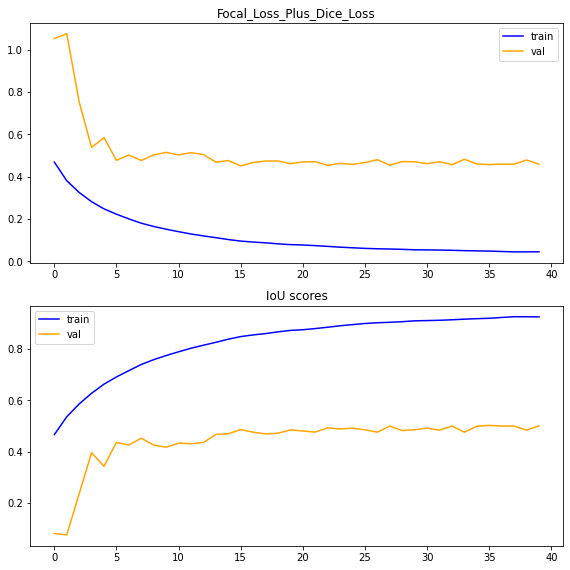

In [ ]:
summarize_diagnostics(history)

Au niveau du set de validation, on constate qu'autour de 15 epochs la fonction de perte ne diminue plus et stagne à environ 0.5. Même situation pour le score IoU, qui tend à se stabiliser au même moment de l'entraînement (dépasse légèrement 0.4).

Vérifions les scores exactes :

In [ ]:
loss, iou, dice = model.evaluate(valid_ds)

32/32 [==============================] - 251s 8s/step - loss: 0.4668 - iou_score: 0.4966 - f1-score: 0.6011


Le score Dice monte, quant à lui, à 0.6.

In [ ]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'loss': sm.losses.categorical_focal_dice_loss})

**Test de prédiction**

In [ ]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, None)

In [ ]:
print(preprocessed_img.shape)
print(preprocessed_img.dtype)

(1, 128, 256, 3)
float64


In [ ]:
predict_baseline = model.predict(preprocessed_img)

1/1 [==============================] - 1s 1s/step


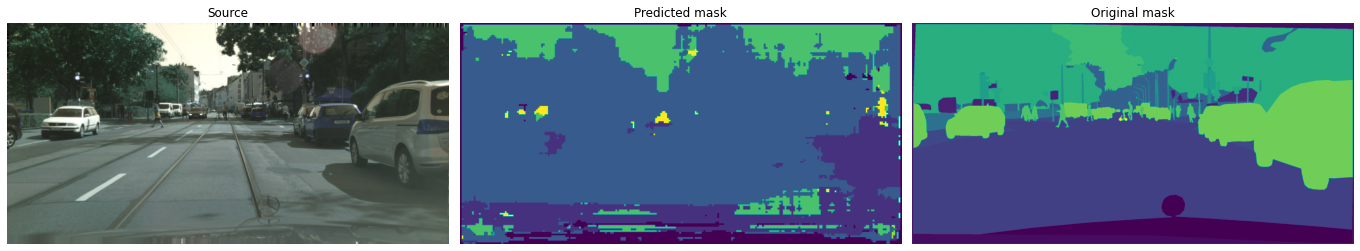

In [ ]:
compare_segmentations(sample_img, sample_mask, predict_baseline)

Une première modélisation donne déjà un aperçu de certaines formes, même si ça reste flou.

In [ ]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [55]:
scorer.show_scores()

In [71]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0  Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968

## Dice loss

In [ ]:
f_loss = sm.losses.DiceLoss()

Préparons le training sets avec notre classe CustomDataGenerator :

In [ ]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=50,
                                        preprocessing=None, 
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=50, 
                                        preprocessing=None,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Définissons et entraînons notre baseline :

In [ ]:
model = get_model_ref((128,256), 8)

model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [ ]:
#model.summary()

In [ ]:
model_name = "Base-Dice"

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
186/186 [==============================] - 293s 2s/step - loss: 0.4807 - iou_score: 0.4091 - f1-score: 0.5193 - val_loss: 0.9430 - val_iou_score: 0.0327 - val_f1-score: 0.0570
Epoch 2/40
186/186 [==============================] - 170s 884ms/step - loss: 0.4367 - iou_score: 0.4581 - f1-score: 0.5633 - val_loss: 0.8685 - val_iou_score: 0.0833 - val_f1-score: 0.1315
Epoch 3/40
186/186 [==============================] - 167s 859ms/step - loss: 0.4008 - iou_score: 0.4852 - f1-score: 0.5992 - val_loss: 0.7010 - val_iou_score: 0.2073 - val_f1-score: 0.2990
Epoch 4/40
186/186 [==============================] - 175s 905ms/step - loss: 0.3811 - iou_score: 0.5017 - f1-score: 0.6189 - val_loss: 0.4983 - val_iou_score: 0.3779 - val_f1-score: 0.5017
Epoch 5/40
186/186 [==============================] - 164s 851ms/step - loss: 0.3602 - iou_score: 0.5216 - f1-score: 0.6398 - val_loss: 0.4668 - val_iou_score: 0.4125 - val_f1-score: 0.5332
Epoch 6/40
186/186 [==============================] -

Vérifions les courbes :

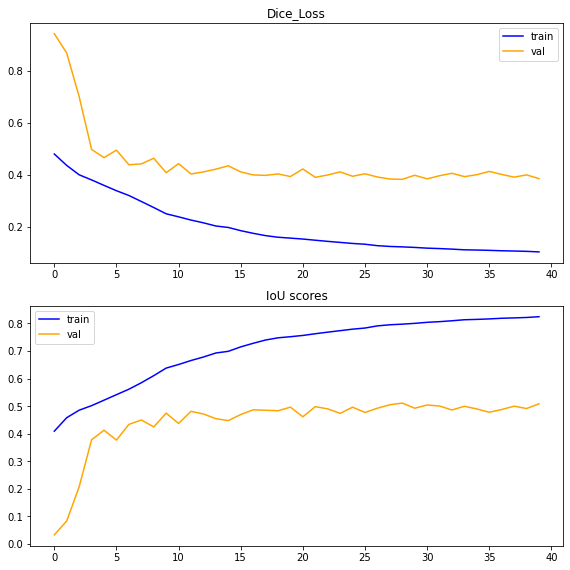

In [ ]:
summarize_diagnostics(history)

Ici également, la fonction de perte et la métrique IoU semblent se stabiliser au bout de 10 epochs, alors que le training set continue a améliorer ses performances. Vérifions les chiffres exacts :

In [ ]:
loss, iou, dice = model.evaluate(valid_ds)

32/32 [==============================] - 165s 5s/step - loss: 0.3778 - iou_score: 0.5132 - f1-score: 0.6222


In [ ]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'dice_loss': sm.losses.DiceLoss()})

**Test de prédiction**

In [ ]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, None)

In [ ]:
predict_base_dice = model.predict(preprocessed_img)

1/1 [==============================] - 0s 460ms/step


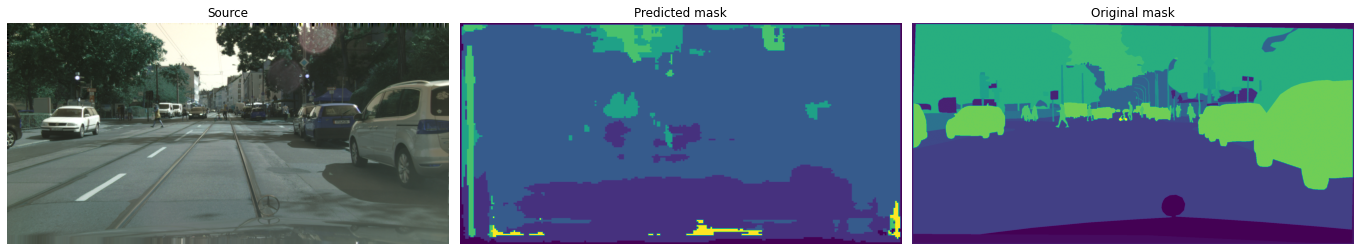

In [ ]:
compare_segmentations(sample_img, sample_mask, predict_base_dice)

Une segmentation peu réussie, il est difficile de distinguer les formes.

In [ ]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [72]:
scorer.show_scores()

In [65]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0  Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968
1              Base-Dice  0.513233  0.622157    7420.738188

## Weighted Dice Loss

La fonction de perte pondérée prend en entrée **une carte de poids**, qui est calculée sur la base de la valeur prédite et de l'erreur obtenue pour chaque instance. Nous allons attribuer un poids de façon manuelle à chaque label, tout en sachant que nous tenons avant tout de détecter les humains et les autres véhicules.

In [ ]:
# Rappel des catégories :
# 0 = void
# 1 = flat
# 2 = construction
# 3 = object
# 4 = nature
# 5 = sky
# 6 = human
# 7 = vehicules

class_w = np.array([0.5,1,1,1,0.5,0.5,2,2])

f_loss = sm.losses.DiceLoss(class_weights=class_w)

Préparons le training sets avec notre classe CustomDataGenerator :

In [ ]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=50,
                                        preprocessing=None, 
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=50, 
                                        preprocessing=None,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Définissons et entrainons la baseline :

In [ ]:
model = get_model_ref((128,256), 8)

model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [ ]:
#model.summary()

In [ ]:
model_name = "Base-Weight-Dice"

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
186/186 [==============================] - 271s 1s/step - loss: 0.5790 - iou_score: 0.3278 - f1-score: 0.4274 - val_loss: 0.9651 - val_iou_score: 0.0207 - val_f1-score: 0.0349
Epoch 2/40
186/186 [==============================] - 186s 965ms/step - loss: 0.5203 - iou_score: 0.3654 - f1-score: 0.4722 - val_loss: 0.8379 - val_iou_score: 0.1215 - val_f1-score: 0.1589
Epoch 3/40
186/186 [==============================] - 176s 904ms/step - loss: 0.4821 - iou_score: 0.3897 - f1-score: 0.4973 - val_loss: 0.7416 - val_iou_score: 0.2088 - val_f1-score: 0.2734
Epoch 4/40
186/186 [==============================] - 175s 909ms/step - loss: 0.4550 - iou_score: 0.4106 - f1-score: 0.5178 - val_loss: 0.7190 - val_iou_score: 0.2218 - val_f1-score: 0.2958
Epoch 5/40
186/186 [==============================] - 188s 970ms/step - loss: 0.4353 - iou_score: 0.4231 - f1-score: 0.5306 - val_loss: 0.5008 - val_iou_score: 0.3745 - val_f1-score: 0.4812
Epoch 6/40
186/186 [==============================] -

Affichons les courbes :

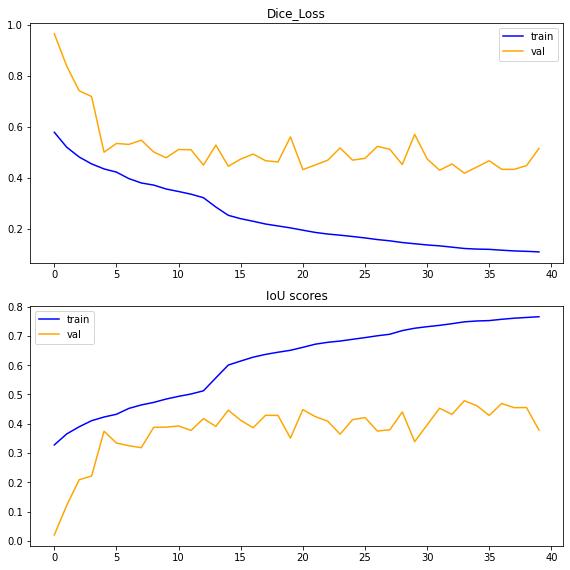

In [ ]:
summarize_diagnostics(history)

La fonction de perte semble diminuer au fur et à mesure des epochs. L'IoU, lui, s'améliore d'epoch en epoch et atteint plus 0.4 à son stade maximal. Au final, le score chute légèrement :

In [ ]:
loss, iou, dice = model.evaluate(valid_ds)

32/32 [==============================] - 143s 5s/step - loss: 0.5108 - iou_score: 0.3875 - f1-score: 0.5073


In [ ]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'weighted_dice_loss': sm.losses.DiceLoss(class_weights=class_w)})

**Test de prédiction**

In [ ]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, None)

In [ ]:
predict_base_weight_dice = model.predict(preprocessed_img)

1/1 [==============================] - 0s 464ms/step


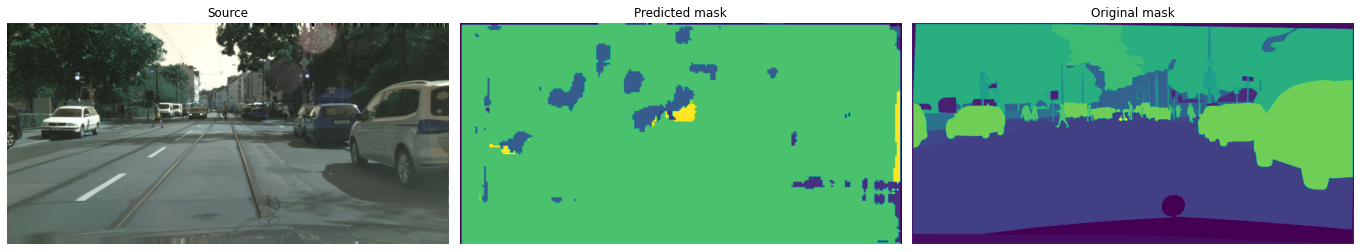

In [ ]:
compare_segmentations(sample_img, sample_mask, predict_base_weight_dice)

Les résultats ne sont pas bons du tout...

In [ ]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [75]:
scorer.show_scores()

In [74]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0  Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968
1              Base-Dice  0.513233  0.622157    7420.738188
2       Base-Weight-Dice  0.387483  0.507299    7506.385689

## Focal loss 

Cette fonction permet de mettre moins de poids sur les exemples bien classifiés, mettant ainsi davantage l'accent lors de l'entraînement sur les données difficiles à classifier. 
On utilise ici le paramètre `gamma` défini à 1.0.

In [ ]:
f_loss = sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=1.0)

Préparons le training sets avec notre classe CustomDataGenerator :

In [ ]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=50,
                                        preprocessing=None, 
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=50, 
                                        preprocessing=None,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Définissons et entrainons le modèle de référence :

In [ ]:
model = get_model_ref((128,256), 8)

model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [ ]:
#model.summary()

In [ ]:
model_name = "Base-Focal"

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
186/186 [==============================] - 550s 3s/step - loss: 0.0250 - iou_score: 0.3587 - f1-score: 0.4778 - val_loss: 0.0536 - val_iou_score: 0.0653 - val_f1-score: 0.1164
Epoch 2/40
186/186 [==============================] - 182s 936ms/step - loss: 0.0124 - iou_score: 0.3957 - f1-score: 0.5198 - val_loss: 0.0397 - val_iou_score: 0.1055 - val_f1-score: 0.1701
Epoch 3/40
186/186 [==============================] - 174s 907ms/step - loss: 0.0100 - iou_score: 0.4399 - f1-score: 0.5653 - val_loss: 0.0356 - val_iou_score: 0.2014 - val_f1-score: 0.2872
Epoch 4/40
186/186 [==============================] - 187s 979ms/step - loss: 0.0080 - iou_score: 0.4874 - f1-score: 0.6114 - val_loss: 0.0256 - val_iou_score: 0.2543 - val_f1-score: 0.3541
Epoch 5/40
186/186 [==============================] - 175s 912ms/step - loss: 0.0066 - iou_score: 0.5262 - f1-score: 0.6492 - val_loss: 0.0213 - val_iou_score: 0.2986 - val_f1-score: 0.4110
Epoch 6/40
186/186 [==============================] -

Affichons les courbes :

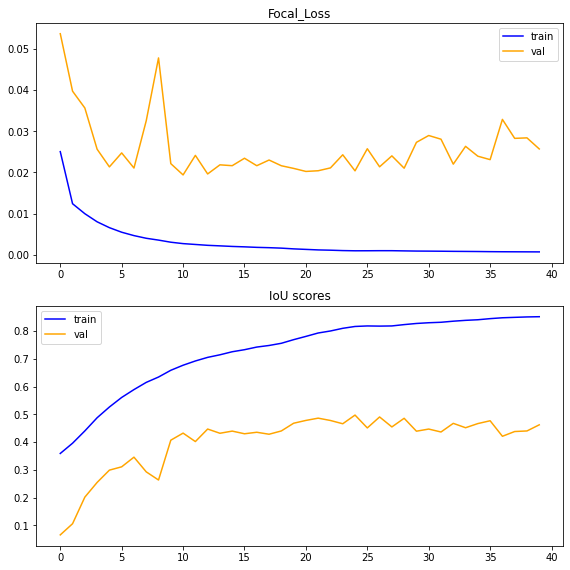

In [ ]:
summarize_diagnostics(history)

La fonction de perte diminue au fil des epochs pour le train set. En revanche, du côté du validation set, l'évolution de la loss n'est pas homogène.

Pour ce qui est de la métrique, une belle évolution au niveau du train set. Le validation set atteint 0.4 déjà au bout de 10 epochs, par la suite la valeur continue à monter très légèrement mais sans jamais atteindre 0.5.

In [ ]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'dice_loss': sm.losses.DiceLoss()})

In [ ]:
loss, iou, dice = model.evaluate(valid_ds)

32/32 [==============================] - 93s 3s/step - loss: 0.0345 - iou_score: 0.4238 - f1-score: 0.5399


**Test de prédiction**

In [ ]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, None)

In [ ]:
predict_base_focal = model.predict(preprocessed_img)

1/1 [==============================] - 1s 1s/step


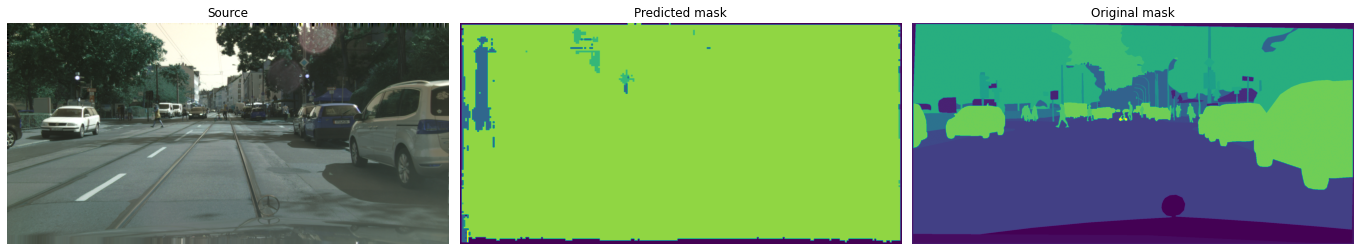

In [ ]:
compare_segmentations(sample_img, sample_mask, predict_base_focal)

La prédiction n'est pas bonne du tout !

In [ ]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [77]:
scorer.show_scores()

In [76]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0  Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968
1              Base-Dice  0.513233  0.622157    7420.738188
2       Base-Weight-Dice  0.387483  0.507299    7506.385689
3             Base-Focal  0.423833  0.539918    7538.611242

## BCE Jaccard loss 

Il s'agit d'une combinaison des fonctions `binary cross entropy et Jaccard`. La BCE n'étant pas adaptée à des datasets déséquilibrés, c'est pour cette raison qu'elle est combinée à la fonction Jaccard, inspirée du **coefficient de Jaccard**. Elle, à son tour, est utilisée pour des datasets déséquilibrés, et souvent utilisée dans les problématiques de segmentation sémantique.

In [ ]:
f_loss = sm.losses.bce_jaccard_loss

Préparons le training sets avec notre classe CustomDataGenerator :

In [ ]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=50,
                                        preprocessing=None, 
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=50, 
                                        preprocessing=None,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Définissons et entrainons un modèle

In [ ]:
model = get_model_ref((128,256), 8)

model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [ ]:
#model.summary()

In [ ]:
model_name = "Base-Jaccard"

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
186/186 [==============================] - 772s 4s/step - loss: 0.7350 - iou_score: 0.4675 - f1-score: 0.5816 - val_loss: 1.7815 - val_iou_score: 0.0633 - val_f1-score: 0.1010
Epoch 2/40
186/186 [==============================] - 193s 1s/step - loss: 0.5793 - iou_score: 0.5480 - f1-score: 0.6616 - val_loss: 1.6704 - val_iou_score: 0.0715 - val_f1-score: 0.1113
Epoch 3/40
186/186 [==============================] - 182s 944ms/step - loss: 0.4979 - iou_score: 0.6069 - f1-score: 0.7181 - val_loss: 1.1933 - val_iou_score: 0.2092 - val_f1-score: 0.2961
Epoch 4/40
186/186 [==============================] - 194s 995ms/step - loss: 0.4369 - iou_score: 0.6524 - f1-score: 0.7605 - val_loss: 0.7732 - val_iou_score: 0.4217 - val_f1-score: 0.5396
Epoch 5/40
186/186 [==============================] - 184s 952ms/step - loss: 0.3870 - iou_score: 0.6907 - f1-score: 0.7942 - val_loss: 0.7987 - val_iou_score: 0.4305 - val_f1-score: 0.5474
Epoch 6/40
186/186 [==============================] - 18

Affichons les courbes :

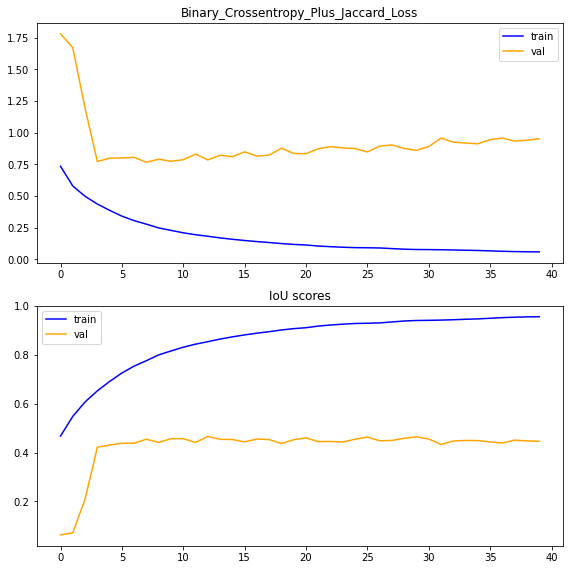

In [ ]:
summarize_diagnostics(history)

Le train set évolue dans la bonne direction. Du côté du validation set, la fonction de perte remonte de façon systématique à partir du 4ème epoch, en oscillant entre 0.75 et 1. La métrique IoU n'évolue plus à partir du 4ème epoch et stagne autour de 0.4.

In [ ]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'dice_loss': sm.losses.DiceLoss()})

In [ ]:
loss, iou, dice = model.evaluate(valid_ds)

32/32 [==============================] - 134s 4s/step - loss: 0.9640 - iou_score: 0.4493 - f1-score: 0.5617


**Test de prédiction**

In [ ]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, None)

In [ ]:
predict_base_jaccard = model.predict(preprocessed_img)

1/1 [==============================] - 1s 1s/step


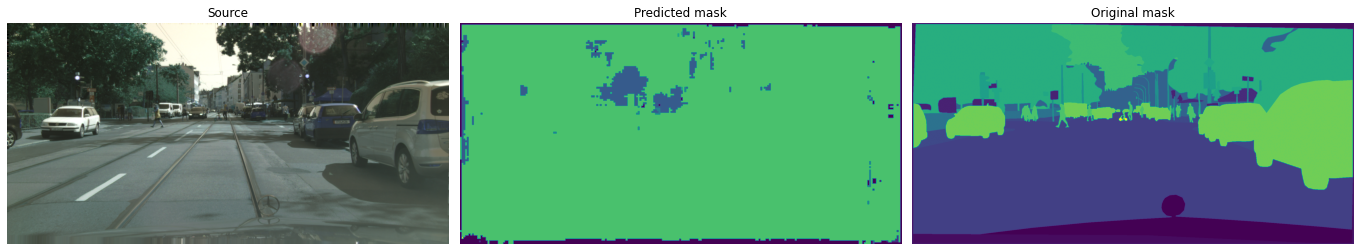

In [ ]:
compare_segmentations(sample_img, sample_mask, predict_base_jaccard)

Une prédiction illisible pour ce modèle.

In [ ]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [80]:
scorer.show_scores()

In [79]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0  Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968
1              Base-Dice  0.513233  0.622157    7420.738188
2       Base-Weight-Dice  0.387483  0.507299    7506.385689
3             Base-Focal  0.423833  0.539918    7538.611242
4           Base-Jaccard  0.449309  0.561707    7876.374853

## Conclusions

Nous avons obtenu les meilleures performances pour deux modèles : 
* `Base-Dice` qui utilise une fonction de coût `sm.losses.DiceLoss()` 
* `Base-Categ-Focal-Dice` uqi utilise la fonction de coût combinée `Focal + Dice`.
Les temps d'exécution sont les plus favorables pour le deuxième modèle. 

Pour les entraînements à venir, nous allons utiliser la fonction de perte combinée. Néanmoins, le modèle final sera retesté avec la fonction de perte Dice pour comparer les résultats.

# Autres architectures <a class="anchor" id="autres">

Nous allons à présent entraîner de différentes architectures.

Les architectures mises en place sont celles venant de `Segmentation models`. C'est la bibliothèque Python de réseaux de neurones destinés à la segmentation d'images et basée sur Keras et TensorFlow.

Nous avons choisi les architectures multi-class `Unet, FPN et Linknet` sur le backbone `Resnet152`.

## U-Net avec Resnet152 <a class="anchor" id="unet_resnet">

**Resnet** - les `Residual Networks` - sont basés sur des résidus ou des skip connections.

Il existe de nombreuses variantes de ResNets :
* `ResNet-34, ResNet-50` qui est composé de 26 millions de paramètres, 
* `ResNet-101` avec 44 millions de paramètres
* `ResNet-152` qui est plus profond avec 152 couches

Dans notre projet, nous allons utiliser le réseau ResNet152 en backbone.

### Sans augmentation <a class="anchor" id="unet_resnet_NOaugm"> </a>

Définissons à présent un pré-processing :

In [28]:
BACKBONE = 'resnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

Préparons le training sets avec notre classe CustomDataGenerator :

In [29]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70,
                                        preprocessing=preprocess_input, 
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70, 
                                        preprocessing=preprocess_input,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Définissons et entrainons un modèle :

In [30]:
# Définition du modèle : UNET + ResNet
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=N_CLASSES, activation=activation)

234326024/234326024 [==============================] - 40s 0us/step


In [31]:
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [32]:
#model.summary()

In [33]:
model_name = "Unet-Resnet-NOaugm"

In [34]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks, 
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
261/261 [==============================] - 702s 3s/step - loss: 0.4214 - iou_score: 0.4825 - f1-score: 0.5988 - val_loss: 0.9479 - val_iou_score: 0.0915 - val_f1-score: 0.1445
Epoch 2/40
261/261 [==============================] - 242s 904ms/step - loss: 0.2968 - iou_score: 0.6108 - f1-score: 0.7247 - val_loss: 0.8365 - val_iou_score: 0.2082 - val_f1-score: 0.2634
Epoch 3/40
261/261 [==============================] - 234s 876ms/step - loss: 0.2622 - iou_score: 0.6464 - f1-score: 0.7583 - val_loss: 0.7163 - val_iou_score: 0.2822 - val_f1-score: 0.3570
Epoch 4/40
261/261 [==============================] - 234s 870ms/step - loss: 0.2387 - iou_score: 0.6711 - f1-score: 0.7807 - val_loss: 0.5162 - val_iou_score: 0.4212 - val_f1-score: 0.5309
Epoch 5/40
261/261 [==============================] - 234s 876ms/step - loss: 0.2127 - iou_score: 0.6998 - f1-score: 0.8049 - val_loss: 0.3565 - val_iou_score: 0.5556 - val_f1-score: 0.6716
Epoch 6/40
261/261 [==============================] -

Affichons les courbes :

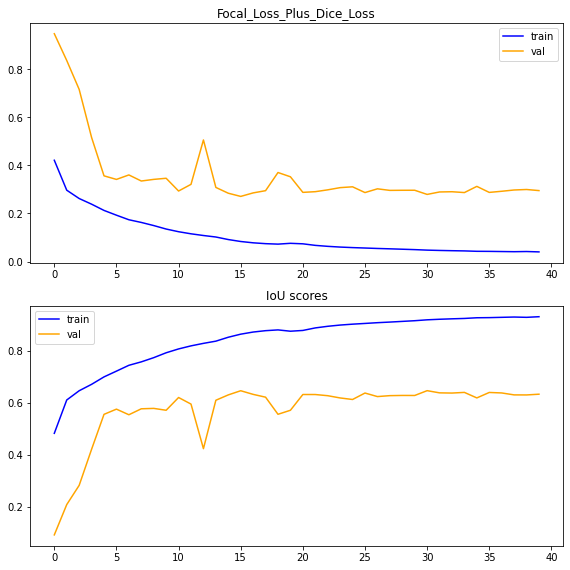

In [36]:
summarize_diagnostics(history)

On observe une stagnation au niveau de la perte (environ 0.3) et du score IoU (environ 0.6) vers 25 epochs.

In [35]:
loss, iou, dice = model.evaluate(valid_ds)

44/44 [==============================] - 326s 8s/step - loss: 0.3238 - iou_score: 0.6115 - f1-score: 0.7191


In [37]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'dice_loss': sm.losses.DiceLoss()})

**Test de prédiction**

In [40]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, preprocess_input)

In [41]:
predict_unet_resnet_noaugm = model.predict(preprocessed_img)

1/1 [==============================] - 0s 34ms/step


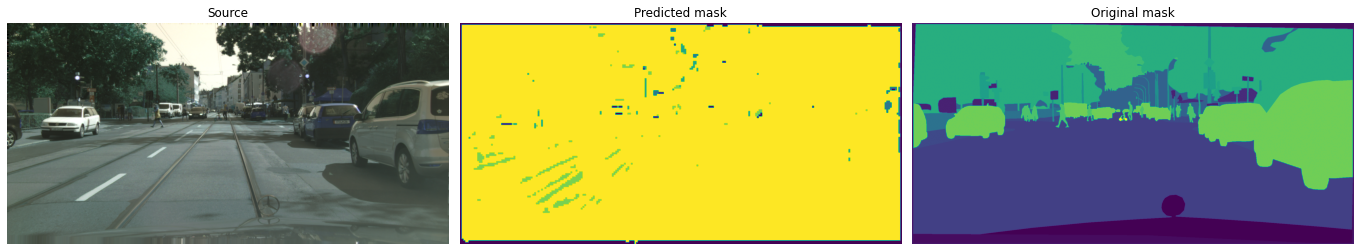

In [44]:
compare_segmentations(sample_img, sample_mask, predict_unet_resnet_noaugm)

La prédiction n'est pas réussie.

In [45]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [82]:
scorer.show_scores()

In [81]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0  Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968
1              Base-Dice  0.513233  0.622157    7420.738188
2       Base-Weight-Dice  0.387483  0.507299    7506.385689
3             Base-Focal  0.423833  0.539918    7538.611242
4           Base-Jaccard  0.449309  0.561707    7876.374853
5     Unet-Resnet-NOaugm  0.611504  0.719118   10515.987629

### Avec augmentation <a class="anchor" id="unet_resnet_augm"> </a>

Définissons à présent un pré-processing :

In [ ]:
BACKBONE = 'resnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

Préparons le training sets avec notre classe CustomDataGenerator :

In [ ]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70,
                                        preprocessing=preprocess_input, 
                                        aug_blur=True, aug_zoom=True, aug_brightness=True, aug_flip=True)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70, 
                                        preprocessing=preprocess_input,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Définissons et entrainons un modèle

In [ ]:
# Définition du modèle : UNET + ResNet
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=N_CLASSES, activation=activation)

In [ ]:
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [ ]:
#model.summary()

In [ ]:
model_name = "Unet-Resnet-augm"

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks, 
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
261/261 [==============================] - 812s 3s/step - loss: 0.4157 - iou_score: 0.4875 - f1-score: 0.6055 - val_loss: 0.9182 - val_iou_score: 0.1111 - val_f1-score: 0.1655
Epoch 2/40
261/261 [==============================] - 509s 2s/step - loss: 0.3014 - iou_score: 0.6010 - f1-score: 0.7213 - val_loss: 0.9164 - val_iou_score: 0.1392 - val_f1-score: 0.2063
Epoch 3/40
261/261 [==============================] - 506s 2s/step - loss: 0.2668 - iou_score: 0.6374 - f1-score: 0.7542 - val_loss: 0.8154 - val_iou_score: 0.2030 - val_f1-score: 0.2904
Epoch 4/40
261/261 [==============================] - 537s 2s/step - loss: 0.2391 - iou_score: 0.6662 - f1-score: 0.7801 - val_loss: 0.4409 - val_iou_score: 0.4858 - val_f1-score: 0.5978
Epoch 5/40
261/261 [==============================] - 513s 2s/step - loss: 0.2208 - iou_score: 0.6856 - f1-score: 0.7973 - val_loss: 0.3789 - val_iou_score: 0.5386 - val_f1-score: 0.6533
Epoch 6/40
261/261 [==============================] - 508s 2s/ste

Affichons les courbes :

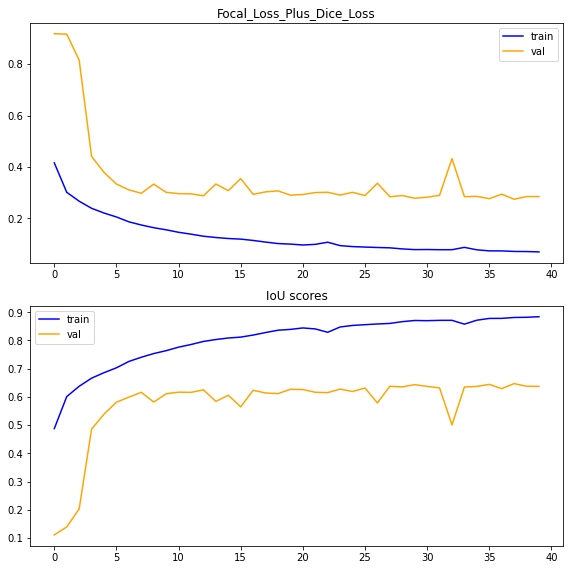

In [ ]:
summarize_diagnostics(history)

On constate qu'au bout de 10 epochs, la fonction perte ne diminue plus, tout comme le score IoU qui se stabilise également. 

In [ ]:
loss, iou, dice = model.evaluate(valid_ds)

44/44 [==============================] - 68s 2s/step - loss: 0.2889 - iou_score: 0.6351 - f1-score: 0.7427


In [ ]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'dice_loss': sm.losses.DiceLoss()})

**Test de prédiction**

In [ ]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, preprocess_input)

In [ ]:
predict_unet_resnet_augm = model.predict(preprocessed_img)

1/1 [==============================] - 4s 4s/step


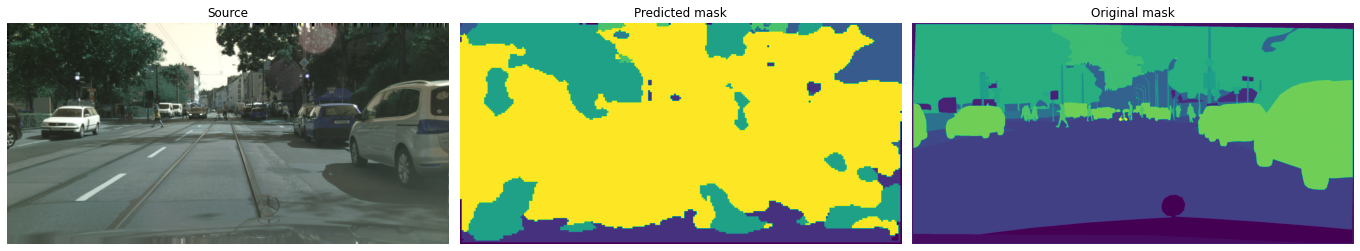

In [ ]:
compare_segmentations(sample_img, sample_mask, predict_unet_resnet_augm)

Une prédiction qui ne semble pas être efficace, toutes les catégories sont mélangées.

In [ ]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [86]:
scorer.show_scores()

In [85]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0  Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968
1              Base-Dice  0.513233  0.622157    7420.738188
2       Base-Weight-Dice  0.387483  0.507299    7506.385689
3             Base-Focal  0.423833  0.539918    7538.611242
4           Base-Jaccard  0.449309  0.561707    7876.374853
5     Unet-Resnet-NOaugm  0.611504  0.719118   10515.987629
6       Unet-Resnet-augm  0.635118  0.742667   21435.816270

## FPN avec Resnet152 <a class="anchor" id="fpn_resnet">

### Sans augmentation <a class="anchor" id="fpn_resnet_NOaugm"> </a>

Définissons à présent un pré-processing :

In [ ]:
BACKBONE = 'resnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

Préparons le training sets avec notre classe CustomDataGenerator :

In [ ]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70,
                                        preprocessing=preprocess_input, 
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70, 
                                        preprocessing=preprocess_input,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Définissons et entrainons un modèle

In [ ]:
# Définition du modèle : FPN + ResNet
model = sm.FPN(BACKBONE, encoder_weights='imagenet', classes=N_CLASSES, activation=activation)

234326024/234326024 [==============================] - 3s 0us/step


In [ ]:
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [ ]:
#model.summary()

In [ ]:
model_name = "FPN-Resnet-NOaugm"

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks, 
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
261/261 [==============================] - 456s 2s/step - loss: 0.3114 - iou_score: 0.5992 - f1-score: 0.7093 - val_loss: 0.9062 - val_iou_score: 0.1421 - val_f1-score: 0.2155
Epoch 2/40
261/261 [==============================] - 240s 899ms/step - loss: 0.2454 - iou_score: 0.6649 - f1-score: 0.7723 - val_loss: 0.9100 - val_iou_score: 0.1419 - val_f1-score: 0.2005
Epoch 3/40
261/261 [==============================] - 239s 896ms/step - loss: 0.1991 - iou_score: 0.7160 - f1-score: 0.8155 - val_loss: 0.8218 - val_iou_score: 0.1918 - val_f1-score: 0.2707
Epoch 4/40
261/261 [==============================] - 245s 917ms/step - loss: 0.1612 - iou_score: 0.7603 - f1-score: 0.8506 - val_loss: 0.4239 - val_iou_score: 0.4976 - val_f1-score: 0.6100
Epoch 5/40
261/261 [==============================] - 241s 904ms/step - loss: 0.1328 - iou_score: 0.7961 - f1-score: 0.8768 - val_loss: 0.3452 - val_iou_score: 0.5789 - val_f1-score: 0.6840
Epoch 6/40
261/261 [==============================] -

Affichons les courbes :

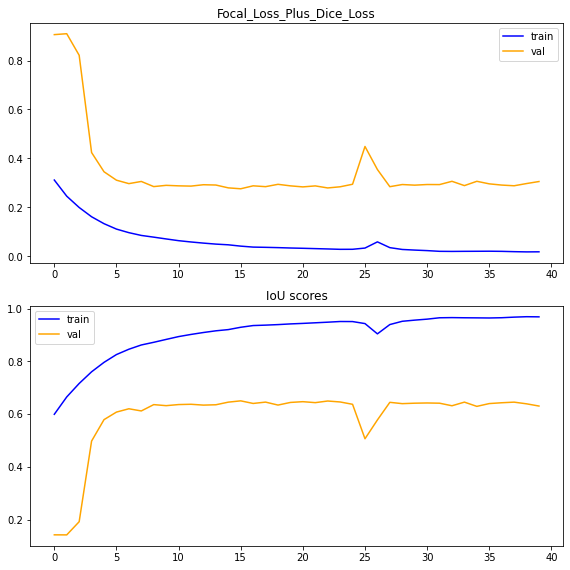

In [ ]:
summarize_diagnostics(history)

Le validation set semble bien apprendre. Le score IoU monte jusqu'à 0.6. La fonction de perte se stabilise à environ 0.3 (au bout de 5 epochs déjà).

In [ ]:
loss, iou, dice = model.evaluate(valid_ds)

44/44 [==============================] - 129s 3s/step - loss: 0.3295 - iou_score: 0.6076 - f1-score: 0.7215


In [ ]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'dice_loss': sm.losses.DiceLoss()})

**Test de prédiction**

In [ ]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, preprocess_input)

In [ ]:
predict_fpn_resnet_noaugm = model.predict(preprocessed_img)

1/1 [==============================] - 4s 4s/step


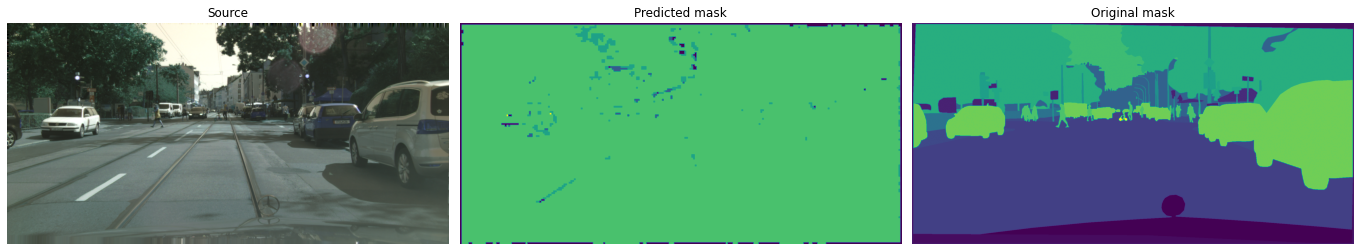

In [ ]:
compare_segmentations(sample_img, sample_mask, predict_fpn_resnet_noaugm)

Une prédiction non informative pourtant...

In [ ]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [93]:
scorer.show_scores()

In [94]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0  Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968
1              Base-Dice  0.513233  0.622157    7420.738188
2       Base-Weight-Dice  0.387483  0.507299    7506.385689
3             Base-Focal  0.423833  0.539918    7538.611242
4           Base-Jaccard  0.449309  0.561707    7876.374853
5     Unet-Resnet-NOaugm  0.611504  0.719118   10515.987629
6       Unet-Resnet-augm  0.635118  0.742667   21435.816270
7      FPN-Resnet-NOaugm  0.607629  0.721474   10060.494859

### Avec augmentation <a class="anchor" id="fpn_resnet_augm"> </a>

Définissons à présent un pré-processing :

In [ ]:
BACKBONE = 'resnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

Préparons le training sets avec notre classe CustomDataGenerator :

In [ ]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70,
                                        preprocessing=preprocess_input, 
                                        aug_blur=True, aug_zoom=True, aug_brightness=True, aug_flip=True)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70, 
                                        preprocessing=preprocess_input,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Définissons et entrainons un modèle

In [ ]:
# Définition du modèle : FPN + ResNet
model = sm.FPN(BACKBONE, encoder_weights='imagenet', classes=N_CLASSES, activation=activation)

234326024/234326024 [==============================] - 37s 0us/step


In [ ]:
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [ ]:
#model.summary()

In [ ]:
model_name = "FPN-Resnet-augm"

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks, 
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
261/261 [==============================] - 880s 3s/step - loss: 0.3326 - iou_score: 0.5719 - f1-score: 0.6904 - val_loss: 0.8642 - val_iou_score: 0.1477 - val_f1-score: 0.2181
Epoch 2/40
261/261 [==============================] - 513s 2s/step - loss: 0.2690 - iou_score: 0.6349 - f1-score: 0.7515 - val_loss: 0.9553 - val_iou_score: 0.1081 - val_f1-score: 0.1650
Epoch 3/40
261/261 [==============================] - 564s 2s/step - loss: 0.2334 - iou_score: 0.6728 - f1-score: 0.7846 - val_loss: 0.6781 - val_iou_score: 0.2880 - val_f1-score: 0.3763
Epoch 4/40
261/261 [==============================] - 521s 2s/step - loss: 0.2010 - iou_score: 0.7099 - f1-score: 0.8146 - val_loss: 0.3563 - val_iou_score: 0.5568 - val_f1-score: 0.6713
Epoch 5/40
261/261 [==============================] - 527s 2s/step - loss: 0.1781 - iou_score: 0.7369 - f1-score: 0.8359 - val_loss: 0.3064 - val_iou_score: 0.6113 - val_f1-score: 0.7168
Epoch 6/40
261/261 [==============================] - 565s 2s/ste

Affichons les courbes :

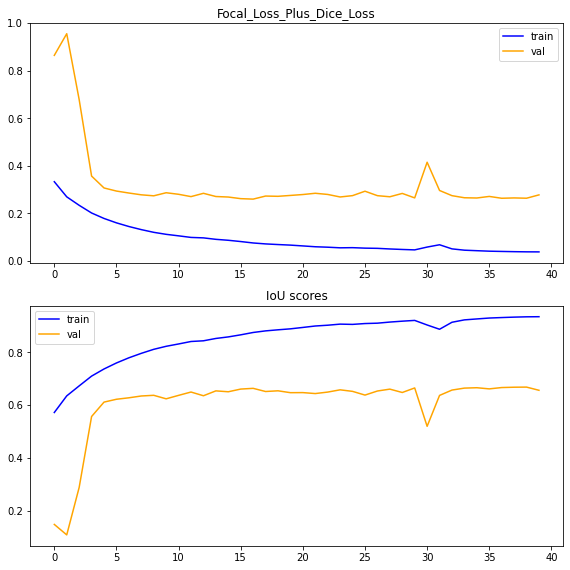

In [ ]:
summarize_diagnostics(history)

La loss function descend jusqu'à environ 0.2 pour le validation set. Le score IoU, quant à lui, atteint plus de 0.6, et c'est un bon résultat.

In [ ]:
loss, iou, dice = model.evaluate(valid_ds)

44/44 [==============================] - 358s 8s/step - loss: 0.2902 - iou_score: 0.6457 - f1-score: 0.7537


In [ ]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'dice_loss': sm.losses.DiceLoss()})

**Test de prédiction**

In [ ]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, preprocess_input)

In [ ]:
predict_fpn_resnet_augm = model.predict(preprocessed_img)

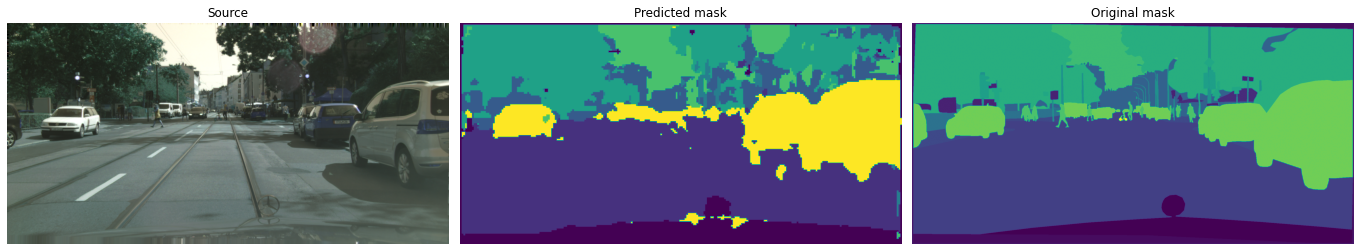

In [ ]:
compare_segmentations(sample_img, sample_mask, predict_fpn_resnet_augm)

Les prédictions prennent des formes ! On distingue facilement des voitures, la route, le ciel et la verdure.

In [ ]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [96]:
scorer.show_scores()

In [100]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0  Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968
1              Base-Dice  0.513233  0.622157    7420.738188
2       Base-Weight-Dice  0.387483  0.507299    7506.385689
3             Base-Focal  0.423833  0.539918    7538.611242
4           Base-Jaccard  0.449309  0.561707    7876.374853
5     Unet-Resnet-NOaugm  0.611504  0.719118   10515.987629
6       Unet-Resnet-augm  0.635118  0.742667   21435.816270
7      FPN-Resnet-NOaugm  0.607629  0.721474   10060.494859
8        FPN-Resnet-augm  0.645746  0.753668   21951.161641

## Linknet avec Resnet <a class="anchor" id="linknet_resnet">

### Sans augmentation <a class="anchor" id="unet_vgg19_NOaugm"> </a>

Définissons à présent un pré-processing :

In [ ]:
#BACKBONE = 'vgg16'
#BACKBONE = 'vgg19'
#BACKBONE = 'densenet201'
#BACKBONE = 'densenet121'
#BACKBONE = 'efficientnetb0'
#BACKBONE = 'efficientnetb7'
BACKBONE = 'resnet152'

preprocess_input = sm.get_preprocessing(BACKBONE)

Préparons le training sets avec notre classe CustomDataGenerator :

In [ ]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70,
                                        preprocessing=preprocess_input, 
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70, 
                                        preprocessing=preprocess_input,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Définissons et entrainons un modèle

In [ ]:
# Définition du modèle : Linknet + ResNet
model = sm.Linknet(BACKBONE, encoder_weights='imagenet', classes=N_CLASSES, activation=activation)

234326024/234326024 [==============================] - 38s 0us/step


In [ ]:
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [ ]:
#model.summary()

In [ ]:
model_name = "Linknet-Resnet-NOaugm"

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
261/261 [==============================] - 678s 2s/step - loss: 0.4547 - iou_score: 0.4562 - f1-score: 0.5666 - val_loss: 0.8069 - val_iou_score: 0.1723 - val_f1-score: 0.2590
Epoch 2/40
261/261 [==============================] - 231s 857ms/step - loss: 0.3163 - iou_score: 0.5974 - f1-score: 0.7045 - val_loss: 0.8278 - val_iou_score: 0.1933 - val_f1-score: 0.2510
Epoch 3/40
261/261 [==============================] - 228s 851ms/step - loss: 0.2804 - iou_score: 0.6305 - f1-score: 0.7409 - val_loss: 0.8552 - val_iou_score: 0.1765 - val_f1-score: 0.2361
Epoch 4/40
261/261 [==============================] - 229s 853ms/step - loss: 0.2582 - iou_score: 0.6531 - f1-score: 0.7617 - val_loss: 0.7192 - val_iou_score: 0.2850 - val_f1-score: 0.3600
Epoch 5/40
261/261 [==============================] - 228s 848ms/step - loss: 0.2324 - iou_score: 0.6807 - f1-score: 0.7858 - val_loss: 0.5409 - val_iou_score: 0.4001 - val_f1-score: 0.5321
Epoch 6/40
261/261 [==============================] -

Affichons les courbes :

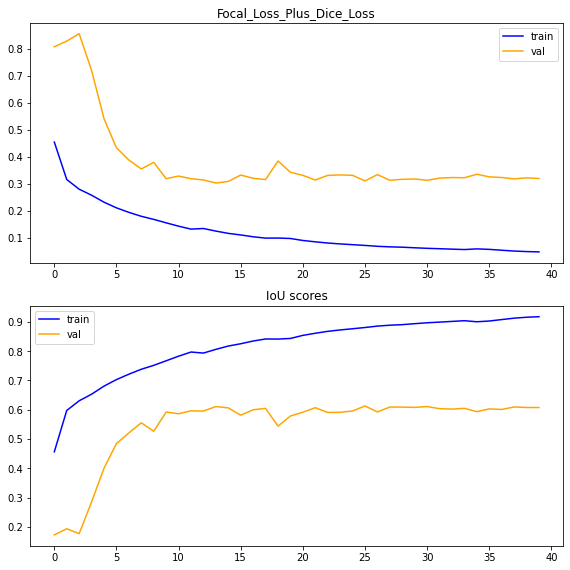

In [ ]:
summarize_diagnostics(history)

Aux alentours de 10 epochs, la fonction de perte ne diminue plus, tout comme le score IoU. L'IoU s'approche de 0.6.

In [ ]:
loss, iou, dice = model.evaluate(valid_ds)

44/44 [==============================] - 322s 7s/step - loss: 0.3207 - iou_score: 0.6087 - f1-score: 0.7216


In [ ]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'dice_loss': sm.losses.DiceLoss()})

**Test de prédiction**

In [ ]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, preprocess_input)

In [ ]:
predict_unet_vgg_noaugm = model.predict(preprocessed_img)

1/1 [==============================] - 4s 4s/step


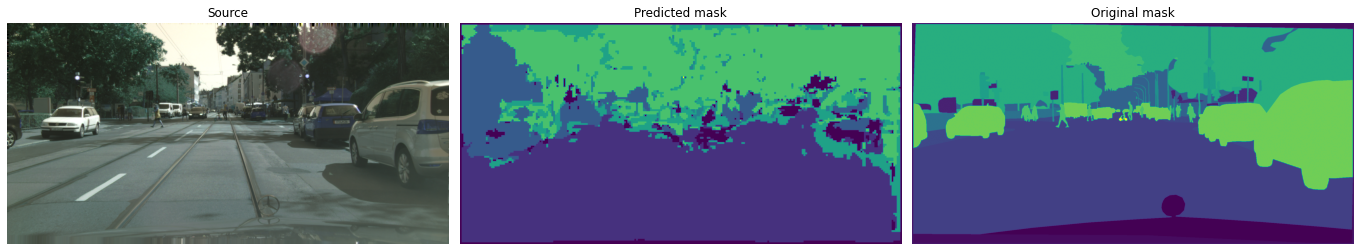

In [ ]:
compare_segmentations(sample_img, sample_mask, predict_unet_vgg_noaugm)

La prédiction est assez approximative. On observe une claire distinction entre la route et le reste des labels. Impossible pourtant d'identifier les humains ou véhicules.

In [ ]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [102]:
scorer.show_scores()

In [101]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0  Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968
1              Base-Dice  0.513233  0.622157    7420.738188
2       Base-Weight-Dice  0.387483  0.507299    7506.385689
3             Base-Focal  0.423833  0.539918    7538.611242
4           Base-Jaccard  0.449309  0.561707    7876.374853
5     Unet-Resnet-NOaugm  0.611504  0.719118   10515.987629
6       Unet-Resnet-augm  0.635118  0.742667   21435.816270
7      FPN-Resnet-NOaugm  0.607629  0.721474   10060.494859
8        FPN-Resnet-augm  0.645746  0.753668   21951.161641
9  Linknet-Resnet-NOaugm  0.608704  0.721641    9976.627367

### Avec augmentation <a class="anchor" id="unet_resnet_augm"> </a>

Définissons à présent un pré-processing :

In [ ]:
BACKBONE = 'resnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

Préparons le training sets avec notre classe CustomDataGenerator :

In [ ]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70,
                                        preprocessing=preprocess_input, 
                                        aug_blur=True, aug_zoom=True, aug_brightness=True, aug_flip=True)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats, 
                                        sample_perc=70, 
                                        preprocessing=preprocess_input,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Définissons et entrainons un modèle

In [ ]:
# Définition du modèle : Linknet + ResNet
model = sm.Linknet(BACKBONE, encoder_weights='imagenet', classes=N_CLASSES, activation=activation)

234326024/234326024 [==============================] - 21s 0us/step


In [ ]:
model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [ ]:
#model.summary()

In [ ]:
model_name = "Linknet-Resnet-augm"

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks, 
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
261/261 [==============================] - 775s 3s/step - loss: 0.4698 - iou_score: 0.4398 - f1-score: 0.5528 - val_loss: 0.8072 - val_iou_score: 0.1658 - val_f1-score: 0.2590
Epoch 2/40
261/261 [==============================] - 474s 2s/step - loss: 0.3304 - iou_score: 0.5745 - f1-score: 0.6935 - val_loss: 0.8717 - val_iou_score: 0.1625 - val_f1-score: 0.2138
Epoch 3/40
261/261 [==============================] - 473s 2s/step - loss: 0.2939 - iou_score: 0.6108 - f1-score: 0.7291 - val_loss: 0.7873 - val_iou_score: 0.2068 - val_f1-score: 0.2899
Epoch 4/40
261/261 [==============================] - 531s 2s/step - loss: 0.2644 - iou_score: 0.6406 - f1-score: 0.7568 - val_loss: 0.4598 - val_iou_score: 0.4592 - val_f1-score: 0.5791
Epoch 5/40
261/261 [==============================] - 517s 2s/step - loss: 0.2422 - iou_score: 0.6634 - f1-score: 0.7775 - val_loss: 0.3381 - val_iou_score: 0.5738 - val_f1-score: 0.6903
Epoch 6/40
261/261 [==============================] - 483s 2s/ste

Affichons les courbes :

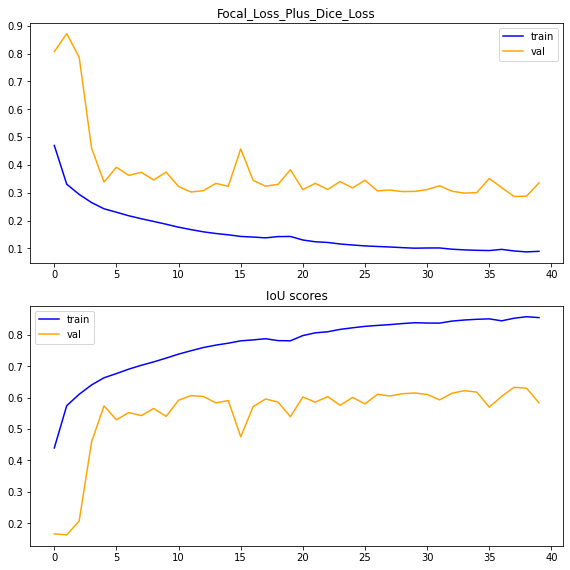

In [ ]:
summarize_diagnostics(history)

Les paramètres semblent se stabiliser encore avant le 5ème epoch : la fonction de perte descend légèrement de 0.4 à 0.3, et le score IoU monte légèrement vers 0.6.

In [ ]:
loss, iou, dice = model.evaluate(valid_ds)

44/44 [==============================] - 265s 6s/step - loss: 0.3370 - iou_score: 0.5852 - f1-score: 0.7022


In [ ]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'dice_loss': sm.losses.DiceLoss()})

**Test de prédiction**

In [ ]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, preprocess_input)

In [ ]:
predict_linknet_resnet_augm = model.predict(preprocessed_img)

1/1 [==============================] - 4s 4s/step


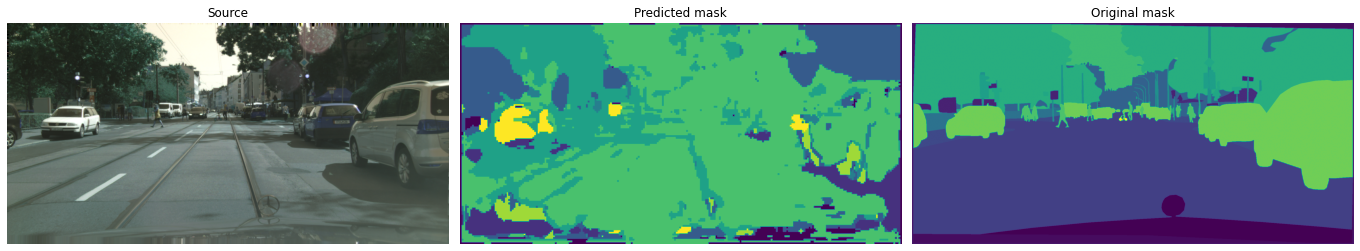

In [ ]:
compare_segmentations(sample_img, sample_mask, predict_linknet_resnet_augm)

Les prédictions permettent de distinguer quelques détails, comme les véhicules et les traits sur la route. On aperçoit le ciel et les arbres. Les piétons ne sont pas reconnus.

In [ ]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [104]:
scorer.show_scores()

In [103]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0   Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968
1               Base-Dice  0.513233  0.622157    7420.738188
2        Base-Weight-Dice  0.387483  0.507299    7506.385689
3              Base-Focal  0.423833  0.539918    7538.611242
4            Base-Jaccard  0.449309  0.561707    7876.374853
5      Unet-Resnet-NOaugm  0.611504  0.719118   10515.987629
6        Unet-Resnet-augm  0.635118  0.742667   21435.816270
7       FPN-Resnet-NOaugm  0.607629  0.721474   10060.494859
8         FPN-Resnet-augm  0.645746  0.753668   21951.161641
9   Linknet-Resnet-NOaugm  0.608704  0.721641    9976.627367
10    Linknet-Resnet-augm  0.585186  0.702199   20616.900008

# Optimisation du modèle final

Nous allons à présent entraîner le modèle avec les meilleurs performances - **le FPN avec augmentation** - avec cette fois-ci la fonction de perte `Dice`, puis comparer les résultats.

Définissons un pré-processing :

In [ ]:
BACKBONE = 'resnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

Préparons le training sets avec notre classe CustomDataGenerator :

In [ ]:
train_ds = CustomDataGenerator(train_images_dir, train_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats,
                                        sample_perc=70,
                                        preprocessing=preprocess_input, 
                                        aug_blur=True, aug_zoom=True, aug_brightness=True, aug_flip=True)

valid_ds = CustomDataGenerator(val_images_dir, val_masks_dir, 
                                        BATCH_SIZE, 128, 256, cats,
                                        sample_perc=70,
                                        preprocessing=preprocess_input,
                                        aug_blur=False, aug_zoom=False, aug_brightness=False, aug_flip=False)

Définissons et entrainons un modèle

In [ ]:
model = sm.FPN(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')

234326024/234326024 [==============================] - 36s 0us/step


In [ ]:
f_loss = sm.losses.DiceLoss()

model.compile(
    optimizer=f_opti,
    loss=f_loss,
    metrics=f_metrics,
)

In [ ]:
#model.summary()

In [ ]:
# remplacé par "Best_with_Dice"
model_name = "Best_High_Resolution"

In [ ]:
t0 = time.perf_counter()
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks, 
    use_multiprocessing=True,
    workers=8 # nb of threads
)
training_time = time.perf_counter() - t0

Epoch 1/40
261/261 [==============================] - 926s 3s/step - loss: 0.3142 - iou_score: 0.5680 - f1-score: 0.6858 - val_loss: 0.9285 - val_iou_score: 0.0498 - val_f1-score: 0.0715
Epoch 2/40
261/261 [==============================] - 556s 2s/step - loss: 0.2607 - iou_score: 0.6233 - f1-score: 0.7393 - val_loss: 0.8263 - val_iou_score: 0.1258 - val_f1-score: 0.1737
Epoch 3/40
261/261 [==============================] - 534s 2s/step - loss: 0.2290 - iou_score: 0.6589 - f1-score: 0.7710 - val_loss: 0.5647 - val_iou_score: 0.3262 - val_f1-score: 0.4353
Epoch 4/40
261/261 [==============================] - 555s 2s/step - loss: 0.2064 - iou_score: 0.6851 - f1-score: 0.7936 - val_loss: 0.3679 - val_iou_score: 0.5120 - val_f1-score: 0.6321
Epoch 5/40
261/261 [==============================] - 556s 2s/step - loss: 0.1873 - iou_score: 0.7082 - f1-score: 0.8127 - val_loss: 0.3111 - val_iou_score: 0.5695 - val_f1-score: 0.6889
Epoch 6/40
261/261 [==============================] - 552s 2s/ste

Affichons les courbes :

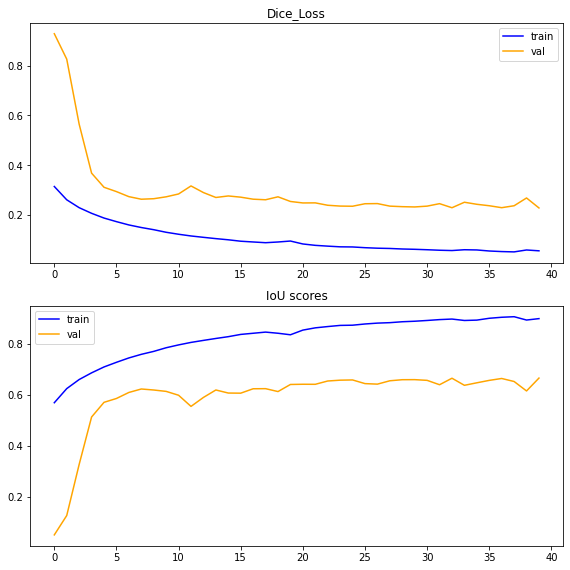

In [ ]:
summarize_diagnostics(history)

Vers 10 epochs on observe une stabilisation au niveau de la fonction de perte (à 0.3 puis descend tout doucement vers 0.2) et du score IoU (qui dépasse 0.6).  Vérifions les chiffres exacts :

In [ ]:
loss, iou, dice = model.evaluate(valid_ds)

44/44 [==============================] - 401s 9s/step - loss: 0.2387 - iou_score: 0.6535 - f1-score: 0.7613


In [ ]:
model.save(SAVE_PATH + f"{model_name}.keras")

In [ ]:
# model = tf.keras.models.load_model(
#         f"/drive/MyDrive/Cityscaper/models/{model_name}.keras",
#         custom_objects={
#             'iou_score': sm.metrics.iou_score,
#             'f1-score': sm.metrics.f1_score,
#             'dice_loss': sm.losses.DiceLoss()})

**Test de prédiction**

In [ ]:
preprocessed_img = preprocess_sample(sample_img, 128, 256, preprocess_input)

In [ ]:
predict_best = model.predict(preprocessed_img)

1/1 [==============================] - 4s 4s/step


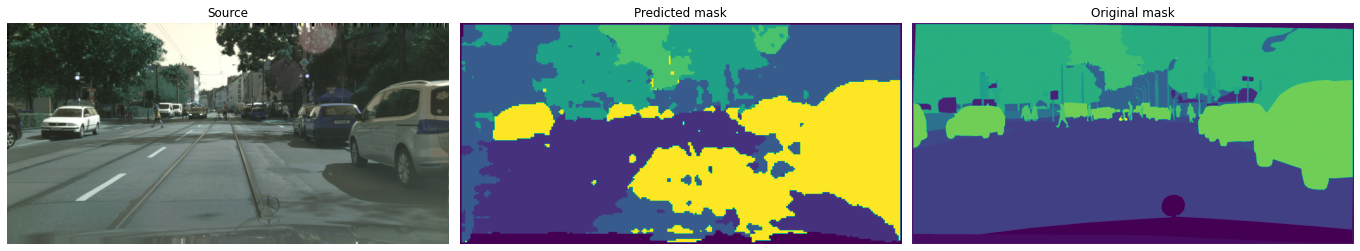

In [ ]:
compare_segmentations(sample_img, sample_mask, predict_best)

Les résultats en chiffres sont meilleurs par rapport aux modèles précédents. En revanche, la segmentation visuelle est moins claire.

In [ ]:
scorer.add_scores(model_name, [iou, dice, training_time])

In [106]:
scorer.show_scores()

# Tableau récapitulatif

Comparons les résultats obtenus par tous les modèles :

In [105]:
pd.read_csv(doc_id)

Model       IoU      Dice  training_time
0   Base-Categ-Focal-Dice  0.496615  0.601135    7261.540968
1               Base-Dice  0.513233  0.622157    7420.738188
2        Base-Weight-Dice  0.387483  0.507299    7506.385689
3              Base-Focal  0.423833  0.539918    7538.611242
4            Base-Jaccard  0.449309  0.561707    7876.374853
5      Unet-Resnet-NOaugm  0.611504  0.719118   10515.987629
6        Unet-Resnet-augm  0.635118  0.742667   21435.816270
7       FPN-Resnet-NOaugm  0.607629  0.721474   10060.494859
8         FPN-Resnet-augm  0.645746  0.753668   21951.161641
9   Linknet-Resnet-NOaugm  0.608704  0.721641    9976.627367
10    Linknet-Resnet-augm  0.585186  0.702199   20616.900008
11         Best_with_Dice  0.653487  0.761291   21772.060686

**Conclusions**

Tous les modèles ont reçu en entrée un échantillon de 70% de données initiales.

Le modèle le plus rapide à l'exécution est `Linknet` sans augmentation de données.
Le modèle qui a tourné le plus longtemps est le `FPN` avec augmentation de données.

Il est intéressant de constater que, de manière générale, les données augmentées ont de meilleurs résultats, sauf pour l'architecture `Linknet`.

Le modèle qui mérite une attention particulière  est le `FPN-Resnet-augm` avec la fonction de perte `Categorical Focal + Dice` :
*   IoU de 0.64
*   Dice de 0.75
*   Temps d'exécution : 6h

Le même modèle entraîné avec la fonction de perte `Dice` (`Best_with_Dice`) obtient les scores légèrement supérieurs : 
*   IoU de 0.65
*   Dice de 0.76
*   Temps d'exécution : 6h

Le choix définitif est donc difficile...

# Choix du modèle final

Nous allons effectuer des prédictions supplémentaires pour comparer les masques proposés par les deux modèles les plus performants :

In [119]:
# Chargement d'images sources et leurs masks
from PIL import Image
sample_img1 = PATH +'/dataset/val_img/munster_000116_000019.png'
sample_mask1 = PATH +'/dataset/val_masks/munster_000116_000019.png'

sample_img2 = PATH +'/dataset/val_img/munster_000173_000019.png'
sample_mask2 = PATH +'/dataset/val_masks/munster_000173_000019.png'

sample_img3 = PATH +'/dataset/val_img/munster_000167_000019.png'
sample_mask3 = PATH +'/dataset/val_masks/munster_000167_000019.png'

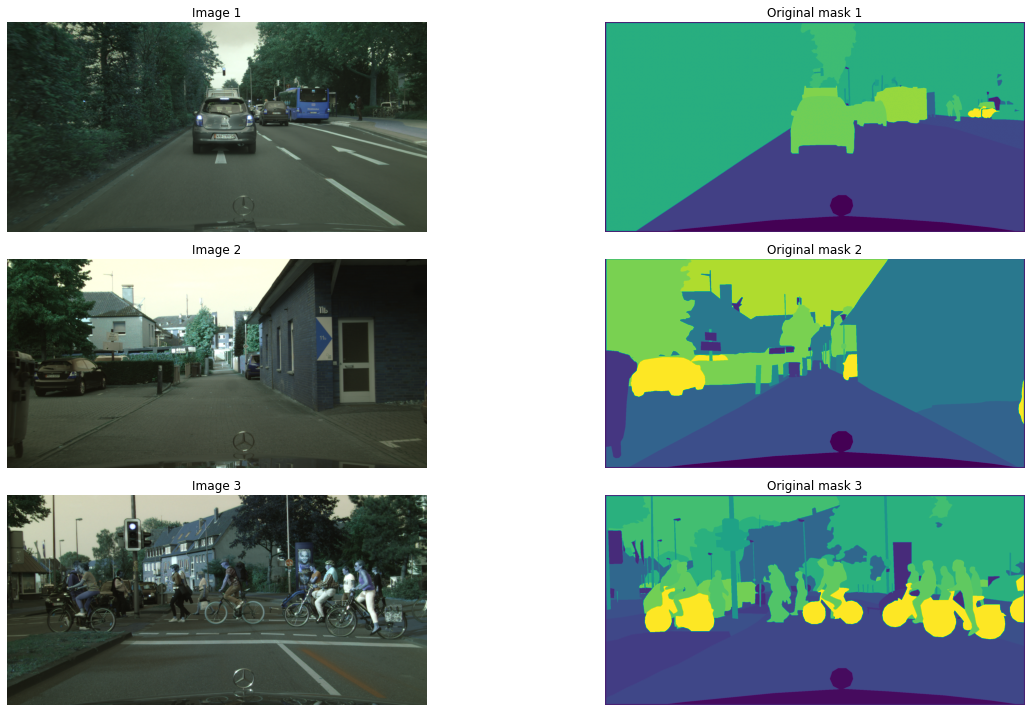

In [122]:
# Affichage des samples
img_source1 = cv2.imread(sample_img1)
mask_source1 = cv2.imread(sample_mask1)
mask_source_last1 = color.rgb2gray(mask_source1)

img_source2 = cv2.imread(sample_img2)
mask_source2 = cv2.imread(sample_mask2)
mask_source_last2 = color.rgb2gray(mask_source2)

img_source3 = cv2.imread(sample_img3)
mask_source3 = cv2.imread(sample_mask3)
mask_source_last3 = color.rgb2gray(mask_source3)
    
fig = plt.figure(figsize=(19,10))

row=3
col=2

plt.subplot(row,col,1)
plt.imshow(np.real(img_source1))
plt.axis('off')
plt.title("Image 1")

plt.subplot(row,col,2)
plt.imshow(np.real(mask_source_last1))
plt.axis('off')
plt.title("Original mask 1")

plt.subplot(row,col,3)
plt.imshow(np.real(img_source2))
plt.axis('off')
plt.title("Image 2")

plt.subplot(row,col,4)
plt.imshow(np.real(mask_source_last2))
plt.axis('off')
plt.title("Original mask 2")

plt.subplot(row,col,5)
plt.imshow(np.real(img_source3))
plt.axis('off')
plt.title("Image 3")

plt.subplot(row,col,6)
plt.imshow(np.real(mask_source_last3))
plt.axis('off')
plt.title("Original mask 3")
    
    
plt.tight_layout()
plt.show()

In [123]:
# Pré-traitement des samples
preprocessed_img1 = preprocess_sample(sample_img1, 128, 256, None)
preprocessed_img2 = preprocess_sample(sample_img2, 128, 256, None)
preprocessed_img3 = preprocess_sample(sample_img3, 128, 256, None)

### Model FPN

Rechargeons le modèle :

In [102]:
model_name = "FPN-Resnet-augm"

In [106]:
model_fpn = tf.keras.models.load_model(
        f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
        custom_objects={
            'iou_score': sm.metrics.iou_score,
            'f1-score': sm.metrics.f1_score,
            'focal_loss_plus_dice_loss': sm.losses.categorical_focal_dice_loss})

Prédiction pour les 3 samples :

In [124]:
predict1 = model_fpn.predict(preprocessed_img1)
predict2 = model_fpn.predict(preprocessed_img2)
predict3 = model_fpn.predict(preprocessed_img3)

1/1 [==============================] - 1s 888ms/step


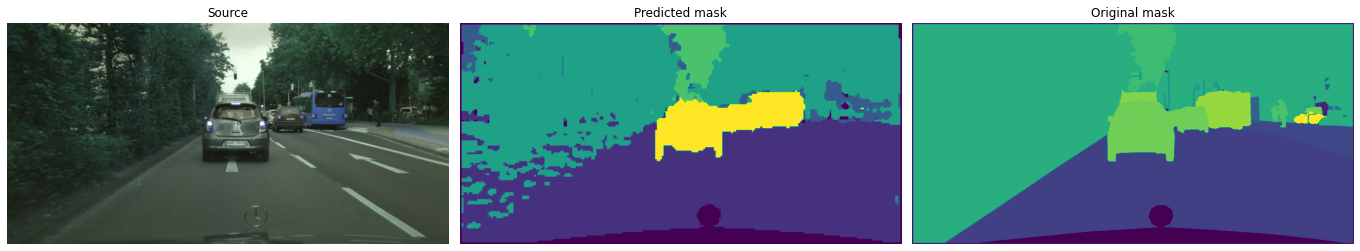

In [111]:
compare_segmentations(sample_img1, sample_mask1, predict1)

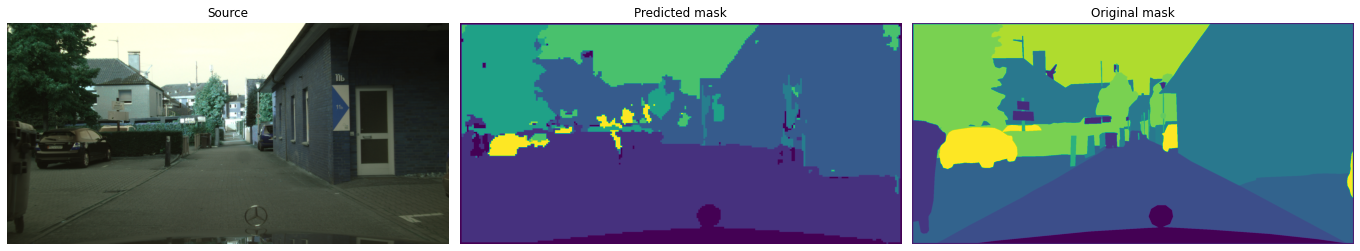

In [112]:
compare_segmentations(sample_img2, sample_mask2, predict2)

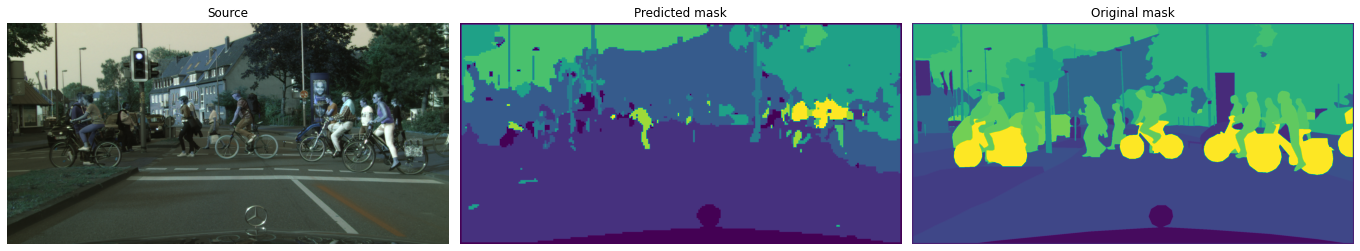

In [125]:
compare_segmentations(sample_img3, sample_mask3, predict3)

### Model Best-Dice

In [114]:
model_name = "Best_High_Resolution"

In [115]:
model_best = tf.keras.models.load_model(
        f"drive/MyDrive/Cityscaper/models/{model_name}.keras",
        custom_objects={
            'iou_score': sm.metrics.iou_score,
            'f1-score': sm.metrics.f1_score,
            'dice_loss': sm.losses.DiceLoss()})

In [126]:
predict1 = model_best.predict(preprocessed_img1)
predict2 = model_best.predict(preprocessed_img2)
predict3 = model_best.predict(preprocessed_img3)

1/1 [==============================] - 1s 909ms/step


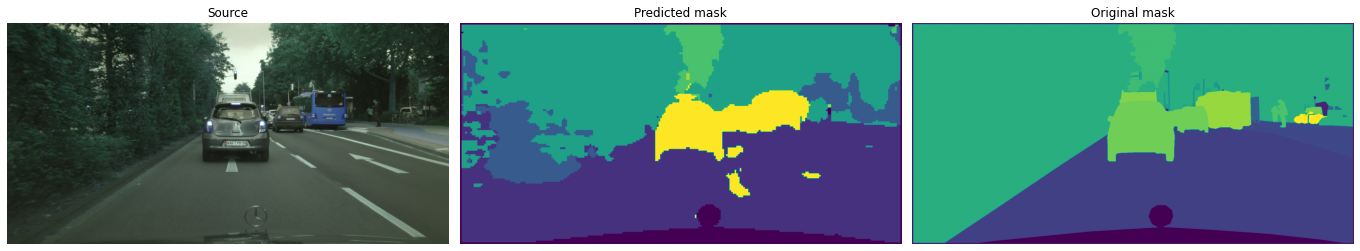

In [117]:
compare_segmentations(sample_img1, sample_mask1, predict1)

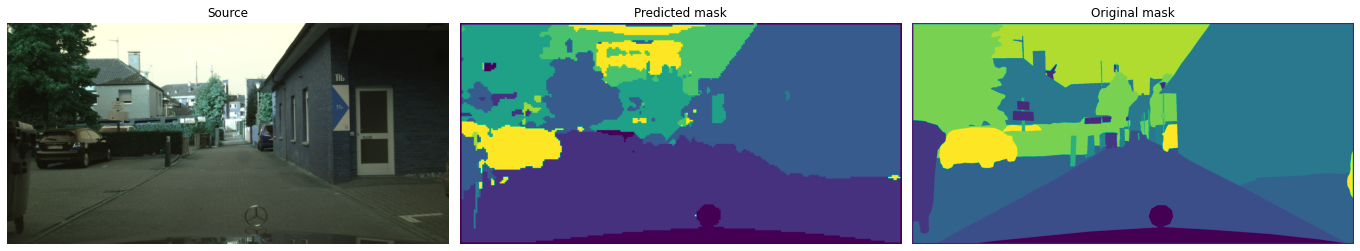

In [118]:
compare_segmentations(sample_img2, sample_mask2, predict2)

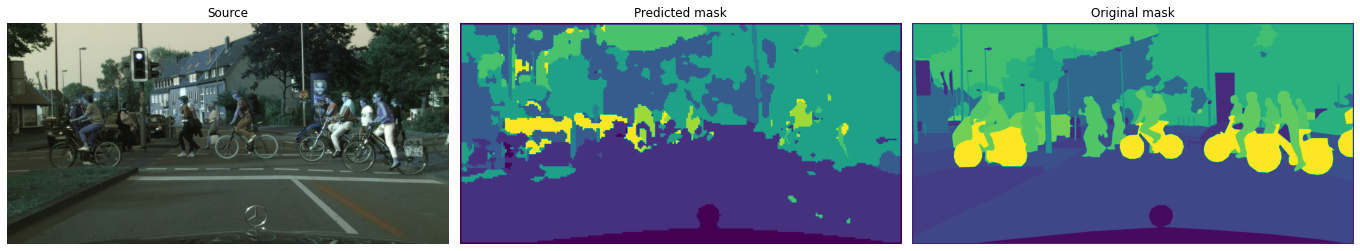

In [127]:
compare_segmentations(sample_img3, sample_mask3, predict3)

### **Conclusion**

Suite aux entraînements et tests effectués et compte-tenu des scores IoU ou Dice, nous constatons que c'est le modèle `FPN` avec des données augmentées et la fonction Dice qui s'en sort le mieux. C'est donc ce modèle qui sera déployé.

# Sources <a class="anchor" id="sources"> </a>
* https://datascientest.com/u-net
* https://github.com/Valkea
* https://inside-machinelearning.com/data-augmentation-ameliorer-rapidement-son-modele-de-deep-learning/
* https://medium.datadriveninvestor.com/keras-training-on-large-datasets-3e9d9dbc09d4
* https://keras.io/examples/vision/oxford_pets_image_segmentation/
* https://blent.ai/unet-computer-vision/
* https://makina-corpus.com/data-science/extraction-objets-cartographie-deep-learning